In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython
from qpsolvers import Problem, solve_problem

In [2]:
import quadrotor

#Constants
print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

m = quadrotor.MASS
r = quadrotor.LENGTH
I = quadrotor.INERTIA
dt = quadrotor.DT
grav = quadrotor.GRAVITY_CONSTANT

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2


## Part 1: Simple SQP

In [3]:
#Helper function to form the cost function
def get_x_des(x):
    center = (0, 1)
    radius = 1
    n = x.shape[0]//8

    # Generate angles starting from -pi/2
    angles = np.linspace(-np.pi / 2, 3 * np.pi / 2, n)

    # Compute x and y coordinates
    x_des = radius * np.cos(angles) + center[0]
    y_des = radius * np.sin(angles) + center[1]

    theta_des = np.zeros((n))

    for i in range(n):
        theta_des[i] = i*math.pi*2/n

    x_diff = np.zeros((x.shape[0], 1))
    n = x.shape[0]//8
    for i in range(n):
        x_diff[8*i] = x_des[i]
        x_diff[8*i + 2] = y_des[i]
        x_diff[8*i + 4] = theta_des[i]

    return x_diff

#Checking the runnning cost by adding up n+1 times
def f(x, x_diff):
    n = x.shape[0]//8
    cost = 0
    for i in range(n):
        cost += 15*((x[8*i] - x_diff[8*i])**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2] - x_diff[8*i+2])**2)
        + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - x_diff[8*i + 4])**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2) 
       
    return cost

def grad_f(x, x_diff):
    df = np.zeros(x.shape[0])
    n = x.shape[0]//8
    for i in range(n):
        df[8*i] = 30*(x[8*i] - x_diff[8*i])
        df[8*i + 1] = 0.2*(x[8*i + 1] - x_diff[8*i + 1])
        df[8*i + 2] = 30*(x[8*i + 2]  - x_diff[8*i + 2])
        df[8*i + 3] = 0.2*(x[8*i + 3] - x_diff[8*i + 3])
        df[8*i + 4] = 30*(x[8*i + 4]  - x_diff[8*i + 4])
        df[8*i + 5] = 0.2*(x[8*i + 5] - x_diff[8*i + 5])
        df[8*i + 6] = 0.2*(x[8*i + 6] - x_diff[8*i + 6])
        df[8*i + 7] = 0.2*(x[8*i + 7] - x_diff[8*i + 7])        

    return df

def hessian(x):
    df = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]//8):
        df[8*i, 8*i] = 30
        df[8*i + 1, 8*i + 1] = 0.2
        df[8*i + 2, 8*i + 2] = 30
        df[8*i + 3, 8*i + 3] = 0.2
        df[8*i + 4, 8*i + 4] = 30
        df[8*i + 5, 8*i + 5] = 0.2
        df[8*i + 6, 8*i + 6] = 0.2
        df[8*i + 7, 8*i + 7] = 0.2

    return df

#g(x) and grad of g(x)
def g(x):
    n = x.shape[0]//8
    g_1 = np.zeros((6*n))
    g_1[0] = x[0]
    g_1[1] = x[1]
    g_1[2] = x[2]
    g_1[3] = x[3]
    g_1[4] = x[4]
    g_1[5] = x[5]
    for i in range(1, n):
        g_1[6*i] = x[8*(i-1) + 8] - x[8*(i-1)] - dt*x[8*(i-1) + 1]
        g_1[6*i + 1] = m*(x[8*(i-1) + 9] - x[8*(i-1) + 1]) +  dt*(x[8*(i-1) + 6] + x[8*(i-1) + 7])*math.sin(x[8*(i-1) + 4])
        g_1[6*i + 2] = x[8*(i-1) + 10] - x[8*(i-1) + 2] - dt*x[8*(i-1) + 3]
        g_1[6*i + 3] = m*(x[8*(i-1) + 11] - x[8*(i-1) + 3]) -  dt*(x[8*(i-1) + 6] + x[8*(i-1) + 7])*math.cos(x[8*(i-1) + 4]) + dt*m*grav
        g_1[6*i + 4] = x[8*(i-1) + 12] - x[8*(i-1) + 4] - dt*x[8*(i-1) + 5]
        g_1[6*i + 5] = I*(x[8*(i-1) + 13] - x[8*(i-1) + 5]) -  dt*r*(x[8*(i-1) + 6] - x[8*(i-1) + 7])
    
    return g_1

#We find this by finding First order approximation of g(x):
# grad_g.dx = -g(x)
def grad_g(x):

    n = x.shape[0]//8
    b = np.zeros((6*n, 8*n))
    b[0][0] = 1
    b[1][1] = 1
    b[2][2] = 1
    b[3][3] = 1
    b[4][4] = 1
    b[5][5] = 1
    for i in range(1, n):
        b[6*i: 6*i + 6, 8*(i-1): 8*(i-1) + 14] = [
            [-1, -dt, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, -m, 0, 0, dt*math.cos(x[8*(i-1) + 4])*((x[8*(i-1) + 6] + x[8*(i-1) + 7])[0]), 0, dt*math.sin(x[8*(i-1) + 4]), dt*math.sin(x[8*(i-1) + 4]), 0, m, 0, 0, 0, 0],
            [0, 0, -1, -dt, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, -m, dt*math.sin(x[8*(i-1) + 4])*((x[8*(i-1) + 6] + x[8*(i-1) + 7])[0]), 0, -dt*math.cos(x[8*(i-1) + 4]), -dt*math.cos(x[8*(i-1) + 4]), 0, 0, 0, m, 0, 0],
            [0, 0, 0, 0, -1, -dt, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, -I, -r*dt, r*dt, 0, 0, 0, 0, 0, I]
        ]

    return b

#h(x) and grad h
def get_u(x):
    n = x.shape[0]//8
    u_1 = np.zeros((4*n))
    for i in range(n):
        u_1[4*i] = -x[8*i + 6]
        u_1[4*i + 1] = x[8*i + 6] - 10
        u_1[4*i + 2] = -x[8*i + 7]
        u_1[4*i + 3] = x[8*i + 7] - 10

    return u_1

#We find this by finding First order approximation of h(x):
# grad_u.dx < -h(x)
def grad_u(x):

    n = x.shape[0]//8
    b = np.zeros((4*n, 8*n))
    for i in range(n):
        b[4*i: 4*i + 4, 8*(i): 8*(i) + 8] = [
            [0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, -1],
            [0, 0, 0, 0, 0, 0, 0, 1],
        ]

    return b

#Checking the constraint violation - sum of absolute values of all constraints g(x) and h(x)
def c(x):
    g_x = g(x)
    constraint_violation = 0
    for i in range(g_x.shape[0]):
        constraint_violation += abs(g_x[i])

    u_x = get_u(x)
    ineq_violation = 0
    for i in range(u_x.shape[0]):
        if u_x[i] > 0:
            ineq_violation+= u_x[i]

    return constraint_violation + ineq_violation

#Filter line search
def line_search(x , x_diff, px , f_best, c_best):
    t = 0.5
    a = 1

    while True:
        if a < 10e-5:
            return a, f_best, c_best
        
        #Calculate running cost with x = x_old + a*px and seeing if it is better than before
        f_t = np.linalg.norm(f(x + a*px, x_diff))
        if f_t < f_best:
            f_best = f_t
            return a, f_best, c_best
        
        #Calculate total constraint violation with x = x_old + a*px and seeing if it is better than before
        c_t = c(x + a*px)
        if c_t < c_best:
            c_best = c_t
            return a, f_best, c_best
    
        #Updating alpha to t*alpha and repeating till condition is met (0 < t < 1)
        a = t*a

def get_ineq_sum(ineq):
    c = 0
    for i in ineq:
        if i > 0:
            c+=i

    return c

In [4]:
#SQP Algorithm 
timesteps = 101
n_vars = 8
n_total = n_vars*timesteps
n_constraints = timesteps*6
n_ineq = timesteps*4

#initialise best running cost and conostraint violation to infiinity just for first iteration in filter line search
f_best = np.inf
c_best = np.inf

alphas = []
costs = []
constr_vio = []
iters = 0

#Start with some arbitrary value of x, lambda and mu

x = np.zeros((n_total, 1))
lmbda = np.zeros((n_constraints, 1))
mu = np.zeros((n_ineq, 1))
print(f"Num of timesteps: {timesteps}")
x_diff = get_x_des(x)

for i in range(100):

    iters += 1

    #Getting all the elements for KKT matrix/QP solver
    hess = hessian(x)
    gradient_f = grad_f(x, x_diff)
    g_x = g(x)
    gradient_g = grad_g(x)
    u_x = get_u(x) 
    gradient_u = grad_u(x) 

    #Solving KKT matrix using QP solver
    problem = Problem(hess, gradient_f, gradient_u, -u_x, gradient_g, -g_x, None, None)

    p = solve_problem(problem, solver="cvxopt")

    px = p.x.reshape((p.x.shape[0], 1))
    plambda = p.y.reshape((p.y.shape[0], 1))
    pmu = p.z.reshape((p.z.shape[0], 1))

    #use line search to find the best value of alpha, by checking when running cost or constraint violation is lower than previous iteration
    a, f_best, c_best = line_search(x, x_diff, px, f_best, c_best)

    #Update x values and Lambda values
    x = x + a*px
    lmbda = (1-a)*lmbda + a*plambda
    mu = (1-a)*mu + a*pmu

    #Threshold for when to stop optimizing is when lagrangian is minimized and constraints are minimized or when maximum iterations are reached
    lagrangian_x = grad_f(x, x_diff) + grad_g(x).transpose()@lmbda + grad_u(x).transpose()@mu
    lagrangian_lmbda = g(x)
    lagrangian_mu = get_u(x)

    print(f"Iteration number{i}")

    lag_x_sum = np.abs(np.sum(lagrangian_x))
    lag_lmbda_sum = np.sum(np.abs(lagrangian_lmbda))
    lag_mu_sum = get_ineq_sum(lagrangian_mu)

    if lag_x_sum < 0.001 or lag_lmbda_sum < 0.0001:
        print("CONVERGED")
        break

Num of timesteps: 101


C:\Users\megh2\AppData\Local\Temp\ipykernel_5432\3513218671.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i] = 30*(x[8*i] - x_diff[8*i])
C:\Users\megh2\AppData\Local\Temp\ipykernel_5432\3513218671.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i + 1] = 0.2*(x[8*i + 1] - x_diff[8*i + 1])
C:\Users\megh2\AppData\Local\Temp\ipykernel_5432\3513218671.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i + 2] = 30*(x[8*i + 2]  - x_diff[8*i + 

Iteration number0
Iteration number1
Iteration number2
Iteration number3
Iteration number4
Iteration number5
Iteration number6
Iteration number7
Iteration number8
Iteration number9
Iteration number10
Iteration number11
Iteration number12
Iteration number13
Iteration number14
Iteration number15
Iteration number16
Iteration number17
Iteration number18
CONVERGED


In [5]:
pxf = []
vxf = []
pyf = []
vyf = []
tf = []
wf = []
uaf = []
ubf = []
for i in range(0, x.shape[0], 8):
    pxf.append(x[i])
    vxf.append(x[i+1])
    pyf.append(x[i+2])
    vyf.append(x[i+3])
    tf.append(x[i+4])
    wf.append(x[i+5])
    uaf.append(x[i+6])
    ubf.append(x[i+7])

uaf = np.array(uaf)
ubf = np.array(ubf)

In [6]:
x_init = np.array([0, 0, 0, 0, 0, 0])
a=6
b=2

#Controllr for simple SQP()
def controller(x1, t):
  return np.array([x[t*(a+b)+6].item(), x[t*(a+b)+7].item()])

t, state, u = quadrotor.simulate(x_init, controller, 101, disturbance=False)
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAZ0dtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EVZliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eIgcgRrmpCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBk/h85TXs1E4/wzb/2kGNoKOUz+RzSfXk3eeTMCjNgTJ5NKBn4bYY/l8VWN5leDx1ux0u0fvaZ
OYTt7nHytnMp39ZMLuXxtXaR7rleXMVFfF/NxUbeBQmwOC7Lx/opNBqhx/5cueJjt7O55GH/QhWB
f591+qoBKpqvyFJzOTzqReBYx8P79mJdx0Mv+HL4+yScuS/TXcCVmU4JjCoFYoGBPXCZbaLTgpjh
suDasRP/PtwZ8v6BnWqdA56T3JCiAPrD40xdk33JyeAAEeaWdSorACoLAwiXnnOc26mL5CXR+eKL
MUrXv/REN/8xsKMQEE+nYeyT0hw4mOEnkCYN+/zwwIsREWnCqX55MlSJGf5c/XE0K8xpX1r539mD
vOO+PAZoTYAwL8cjngQV/5nz3thPImf0/a1N5T6yZu1tjzoHse3v+tdN0uV4G2jgK+k4GzuWiP6s
Ly/vGnzdPSu/HovsbRlJuTm+NW33sVLnleA3kOe50ttkrfrkZuIo2Df6Zxuh4RWwlh9fVOMQXNip
eAJrEkAY11GSKq0e2jckQgnA1wIE/JAGvPThnqiteYzJ+rHdDjvRDxjizQvzJw2ilMA17cON1e79
gFjlxLksBleofhQMhU9yZLftyTJibD0+xKW263wFiIBO+UJi1zPBkwP4B7dT60A+IF5RN+BJzps8
x1CyqUDUkLFhU4H+/QIRfcUUGtHwRyuKg1dw0rtSb4S2TMflaG2k7vfLINiex7WijcrwvSnpW5CQ
tTVsdf9/sASCi3STNjAAI3QP3j71KHZs3OEpba/H3hcvtr9MBlKw1cNPjpUhgHPy4YhDTGRl1PAn
AYtr/WMO/iIbf3q49CC+RBuAmdNjM6R8iFTJLxY2W5yXd3Rk9Hk/bEO7SxJNkKdxjgJlKnBlpYTs
WQ4XEj1eDYqC+oHPnkZDYCOMZjCw/4ury+8lzuYinXn7VCCsEZb0IHhQDBOW3y7wyOLrekH26WY1
kt6ug2QRsChaFFvbMW3RVs8xHlXVPTieI3C+m/ITOs+fEkLqgrub70Z8FhkDGsqs7RZA/ko0UL+7
sOnXf57Gjv4XwPdSPp/pNkrYmAVWYw3O9fGUJkTSevfkICFPE9F80Ghm+MmDnR/UYFXqglcz8Rvj
XBjJWZBNPkZDQq9KfwTv3jUFbQXvlQFSrUEfBSy270HSEP+xi8mfJtuMry54dhBJmpcwf6Vi7S2Z
aIcO+VHSuVkI5hmka8wsL

In [7]:
x_init = np.array([0, 0, 0, 0, 0, 0])
a=6
b=2

#Controllr for simple SQP()
def controller(x1, t):
  return np.array([x[t*(a+b)+6].item(), x[t*(a+b)+7].item()])

t, state, u = quadrotor.simulate(x_init, controller, 101, disturbance=True)
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAARXhtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EWdliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eKwmYcBqJCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBk/h85TXs1E4/wzb/2kGNoKOUz+R0hGEPrybvPJmBRmwJk8mlAz8NsMfy+KrG8kWB463Y6XaP3
tMnMJ29zj5WzmUnXaIt7l8bV2ke65XlzFRXxfzcVG3gUJsDguy8fwKNRqhx/5cueJjt7O55GH/Qh
Lsk/VS+25g47XNs1JzOTzqReBYx8P79mJdx0Mv8Obx3Wj9cf5tXLnMMU2+EU9iCk5ueiEymTouky
fXQhZPaD/rHpMFL+PLUi+8WrjGiQohLwxQF4e8KURvuAABLmlnUqKwAqCwMIl55znNupi8+H0mY6
V5fBQQv0hIJsTonAAe/bPsG71bbHUZdfpDQOB8hIlVKlbAsHDiY4SeQIxnf++bnFiHIA1rd77pbO
gow9vsnTEhOkxlfWkvjhTxFVnQ8BmhI2p0bHG/FgMwWLEXfa5LJF1u/YJsJzjmWjKVuW1C0iu6PW
tR6aXbU2ZSQWQ6tw6nCvfKliUeQeIGsJyOiNn2L+KyYgm6L2hexUueV4DeQ47ZhlAwmCyJJiNiCA
bBXYqlnibY8gMZ7O9+BX/RUCMHia6rMWAJk596J6wQX6ermOqG/JIyPnaxnqvteYzKAAzcV6Zfdq
OygL62f5YfMrBAjZGHkXm+gVhM8xE+5/fplDpnhD5fy6KkJqcvYyjGa+5JEAvN0mVAmoGwRQfwI1
EVTDR5sFBkD5aOiqvLyLbPq7XbAxviEv0CEYO4gT8Q706gkwPT79RpyfqSWyffwFknTSrAV90vl5
upUfSeR+oRtRLoZl42oYQPcvgXndrllRPuoUWgp8/Y1sLRohee4SmPk+nN2bKVP6wGUrDVc0+Ood
fK+UuEoyQWGJVPAnAYxO7Wdz/tPh9LV0JhJoa5YBYi43QOhnzb///7XmsoRWoTH/muLc+pVULzbG
4MiVM6Iw1Q9VpA2fYItEmco9iASTIBBSD695YRJ11YEDG6aO6t0JrFz9umm026r9pbfG2hYW62OI
fs9xipd8N2wjZ3+wwNIWWVHfX4t4C4jK1wmjCZxZL84dYQT1lYJsDiYbOMTnVmTnR2bdeYZVwiBg
74LIDNNeFHr0KfKtl+urzUTq5o0RYM3vFVmMHvPjeI3c69BR/yEJBorC9mhbEmGEyJ2qXjYbUKv/
H78foBXTfkJZIUb3+yGhV6VHbCO76twU8zTURXHlx2y3CfBX1IPoiv8VRRCmBxh5XTmSPwHdOUmQ
mDnHvtIaqg4dchiFH53Nc

In [7]:
states = [pxf, vxf, pyf, vyf, tf, wf]
controls = [uaf, ubf]

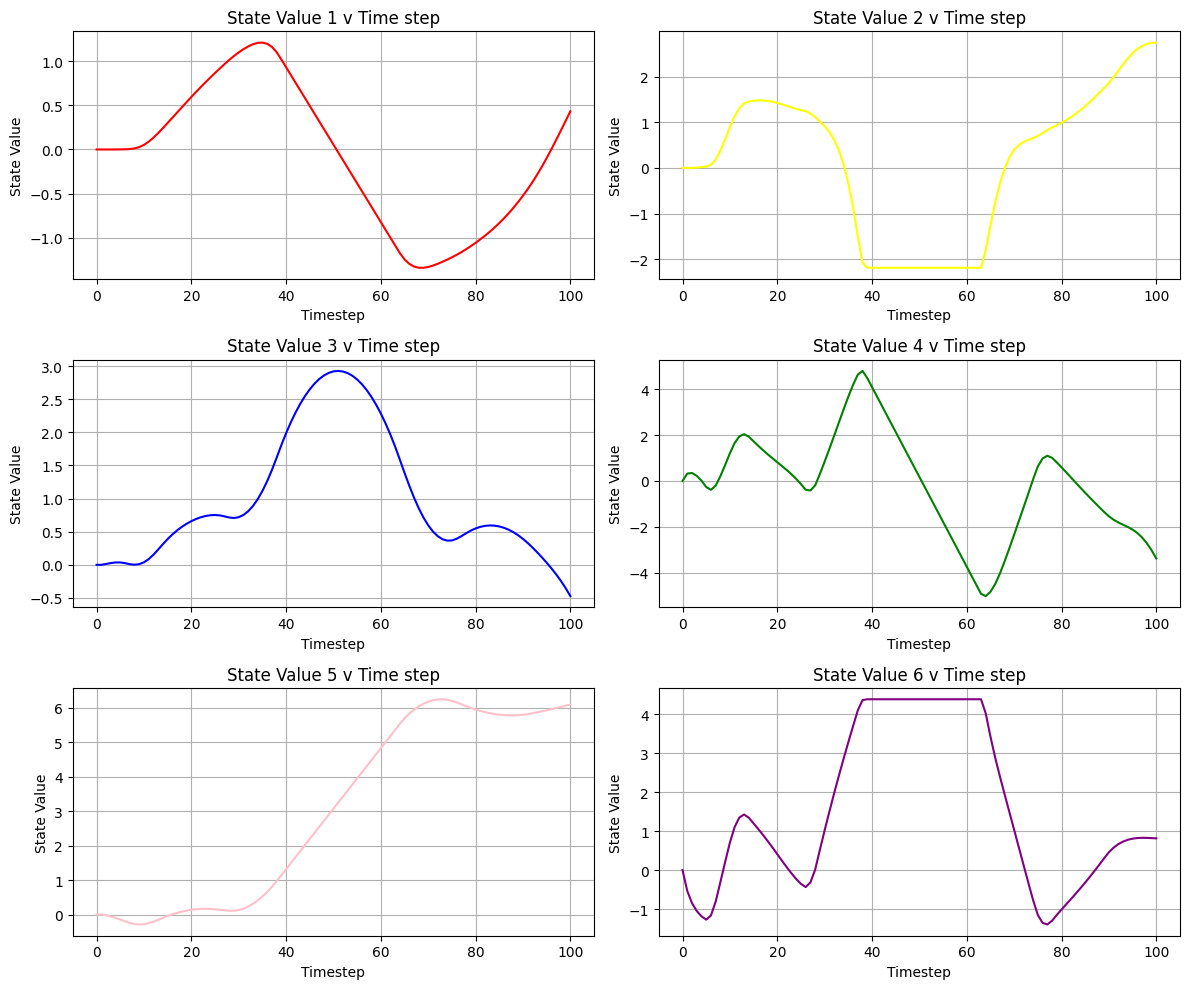

In [8]:
#To plot the graph of state x with each timestep
timesteps = list(range(101))
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
colors = ["red", "yellow", "blue", "green", "pink", "purple"]
axs = axs.flatten()

# Plot each state value in a separate subplot
for i in range(6):
    axs[i].plot(timesteps, states[i], color = colors[i])
    axs[i].set_title(f'State Value {i+1} v Time step')
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel('State Value')
    axs[i].grid()

plt.tight_layout()
plt.show()

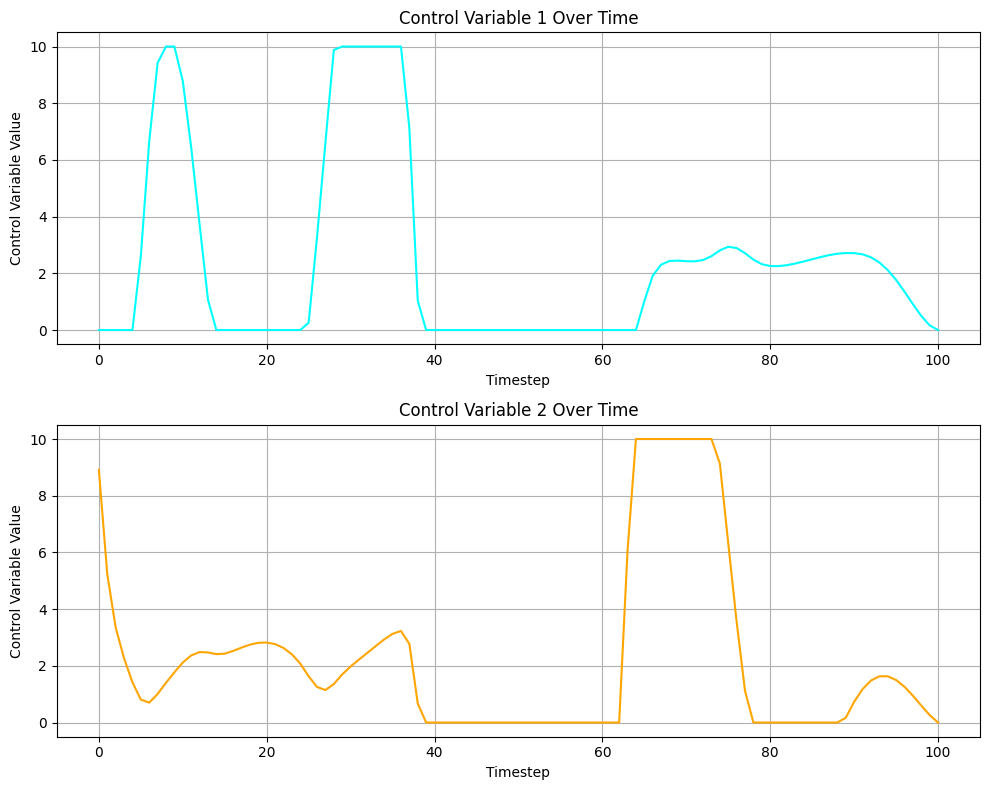

In [9]:
#To plot the graph of control u with each timestep
timesteps = list(range(101))
control1, control2 = controls

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot the first control variable
axs[0].plot(timesteps, control1, linestyle='-', color='cyan')
axs[0].set_title('Control Variable 1 Over Time')
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Control Variable Value')
axs[0].grid()

# Plot the second control variable
axs[1].plot(timesteps, control2, linestyle='-', color='orange')
axs[1].set_title('Control Variable 2 Over Time')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Control Variable Value')
axs[1].grid()


plt.tight_layout()
plt.show()

## Part 2: MPC

In [10]:
#Common SQP Functions

#Choose cost function based on path in controller
def f_n(x, path):
    n = x.shape[0]//8
    cost = 0
    if path == 0:
        for i in range(n):
            cost += 15*((x[8*i] - 1)**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2] - 1)**2)
            + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - (math.pi/2))**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2)  
    elif path == 1:
        for i in range(n):
            cost += 15*((x[8*i])**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2] - 2)**2)
            + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - math.pi)**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2) 
    elif path == 3:
        for i in range(n):
            cost += 15*((x[8*i])**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2])**2)
            + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - (2*math.pi))**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2) 

    return cost
        
def grad_f_n(x, path):
    df = np.zeros(x.shape[0])
    n = x.shape[0]//8

    if path == 0:
        for i in range(n):
            df[8*i] = 30*(x[8*i] - 1)
            df[8*i + 1] = 0.2*(x[8*i + 1])
            df[8*i + 2] = 30*(x[8*i + 2]  - 1)
            df[8*i + 3] = 0.2*(x[8*i + 3])
            df[8*i + 4] = 30*(x[8*i + 4]  - (math.pi/2))
            df[8*i + 5] = 0.2*(x[8*i + 5])
            df[8*i + 6] = 0.2*(x[8*i + 6])
            df[8*i + 7] = 0.2*(x[8*i + 7])      

    if path == 1:
        for i in range(n):
            df[8*i] = 30*(x[8*i])
            df[8*i + 1] = 0.2*(x[8*i + 1])
            df[8*i + 2] = 30*(x[8*i + 2]  - 2)
            df[8*i + 3] = 0.2*(x[8*i + 3])
            df[8*i + 4] = 30*(x[8*i + 4]  - (math.pi))
            df[8*i + 5] = 0.2*(x[8*i + 5])
            df[8*i + 6] = 0.2*(x[8*i + 6])
            df[8*i + 7] = 0.2*(x[8*i + 7])       

    if path == 3:
        for i in range(n):
            df[8*i] = 30*(x[8*i])
            df[8*i + 1] = 0.2*(x[8*i + 1])
            df[8*i + 2] = 30*(x[8*i + 2])
            df[8*i + 3] = 0.2*(x[8*i + 3])
            df[8*i + 4] = 30*(x[8*i + 4]  - (2*math.pi))
            df[8*i + 5] = 0.2*(x[8*i + 5])
            df[8*i + 6] = 0.2*(x[8*i + 6])
            df[8*i + 7] = 0.2*(x[8*i + 7])       

    return df    

def g_n(x, x_start):
    n = x.shape[0]//8
    g_1 = np.zeros((6*n))
    g_1[0] = x[0] - x_start[0]
    g_1[1] = x[1] - x_start[1]
    g_1[2] = x[2] - x_start[2]
    g_1[3] = x[3] - x_start[3]
    g_1[4] = x[4] - x_start[4]
    g_1[5] = x[5] - x_start[5]
    for i in range(1, n):
        g_1[6*i] = x[8*(i-1) + 8] - x[8*(i-1)] - dt*x[8*(i-1) + 1]
        g_1[6*i + 1] = m*(x[8*(i-1) + 9] - x[8*(i-1) + 1]) +  dt*(x[8*(i-1) + 6] + x[8*(i-1) + 7])*math.sin(x[8*(i-1) + 4])
        g_1[6*i + 2] = x[8*(i-1) + 10] - x[8*(i-1) + 2] - dt*x[8*(i-1) + 3]
        g_1[6*i + 3] = m*(x[8*(i-1) + 11] - x[8*(i-1) + 3]) -  dt*(x[8*(i-1) + 6] + x[8*(i-1) + 7])*math.cos(x[8*(i-1) + 4]) + dt*m*grav
        g_1[6*i + 4] = x[8*(i-1) + 12] - x[8*(i-1) + 4] - dt*x[8*(i-1) + 5]
        g_1[6*i + 5] = I*(x[8*(i-1) + 13] - x[8*(i-1) + 5]) -  dt*r*(x[8*(i-1) + 6] - x[8*(i-1) + 7])
    
    return g_1

#Gradient of equality constraints and all inequaity constraints stay the same as before

def c_n(x, x_start):
    g_x = g_n(x, x_start)
    constraint_violation = 0
    for i in range(g_x.shape[0]):
        constraint_violation += abs(g_x[i])

    u_x = get_u(x)
    ineq_violation = 0
    for i in range(u_x.shape[0]):
        if u_x[i] > 0:
            ineq_violation+= u_x[i]

    return constraint_violation + ineq_violation

def line_search_n(x, px , f_best, c_best, path, x_start):
    t = 0.5
    a = 1

    while True:
        if a < 10e-5:
            return a, f_best, c_best
        
        #Calculate running cost with x = x_old + a*px and seeing if it is better than before
        f_t = np.linalg.norm(f_n(x + a*px, path))
        if f_t < f_best:
            f_best = f_t
            return a, f_best, c_best
        
        #Calculate total constraint violation with x = x_old + a*px and seeing if it is better than before
        c_t = c_n(x + a*px, x_start)
        if c_t < c_best:
            c_best = c_t
            return a, f_best, c_best
    
        #Updating alpha to t*alpha and repeating till condition is met (0 < t < 1)
        a = t*a

In [11]:
def do_SQP(x_start, path):
    timesteps = 75
    n_vars = 8
    n_total = n_vars*timesteps
    n_constraints = timesteps*6
    n_ineq = timesteps*4

    #initialise best running cost and conostraint violation to infiinity just for first iteration in filter line search
    f_best = np.inf
    c_best = np.inf

    alphas = []
    costs = []
    constr_vio = []
    iters = 0

    #Start with starting values of x0 and arbitrary lambda

    x = np.zeros((n_total, 1))
    x[:6] = x_start.reshape((6,1))
    lmbda = np.zeros((n_constraints, 1))
    mu = np.zeros((n_ineq, 1))
    # print(f"Num of timesteps: {timesteps}")

    for i in range(50):
        iters += 1
        #Getting all the elements for KKT matrix
        hess = hessian(x)
        gradient_f = grad_f_n(x, path)
        g_x = g_n(x, x_start)
        gradient_g = grad_g(x)
        u_x = get_u(x)
        gradient_u = grad_u(x)

        problem = Problem(hess, gradient_f, gradient_u, -u_x, gradient_g, -g_x, None, None)

        p = solve_problem(problem, solver="cvxopt")

        px = p.x.reshape((p.x.shape[0], 1))
        plambda = p.y.reshape((p.y.shape[0], 1))
        pmu = p.z.reshape((p.z.shape[0], 1))

        a, f_best, c_best = line_search_n(x, px, f_best, c_best, path, x_start)
        # print(f"best alpha is {a}\n")

        #Update x values and Lambda values
        x = x + a*px
        lmbda = (1-a)*lmbda + a*plambda
        mu = (1-a)*mu + a*pmu

        #Threshold for when to stop optimizing is when lagrangian is minimized and constraints are minimized or when maximum iterations are reached
        lagrangian_x = grad_f_n(x, path) + grad_g(x).transpose()@lmbda + grad_u(x).transpose()@mu
        lagrangian_lmbda = g_n(x, x_start)
        lagrangian_mu = get_u(x)

        # print(f"Iteration number{i}")

        lag_x_sum = np.abs(np.sum(lagrangian_x))
        lag_lmbda_sum = np.sum(np.abs(lagrangian_lmbda))
        lag_mu_sum = get_ineq_sum(lagrangian_mu)


        constr_vio.append(lag_lmbda_sum)
        alphas.append(a)
        costs.append(np.sum(f_n(x, path)))

        # print(f"Min lagrangian is {lag_x_sum}\nConstraints sum is {lag_lmbda_sum}\nInequality Constraints sum is {lag_mu_sum}\n Cost is {np.sum(f_n(x, path))}")
        if lag_x_sum < 0.01 or lag_lmbda_sum < 0.01:
            break    

    x_guess = x[8:16]
    ua, ub = x[6], x[7]

    return ua, ub

In [12]:
x_init = np.array([0, 0, 0, 0, 0, 0])
a=6
b=2

def controller(x1, t):

  if t <= 30:
    path = 0
  elif t <= 100:
    path = 1
  else:
    path = 3

  ua, ub = do_SQP(x1, path)
  return np.array([ua.item(), ub.item()])

t, state, u = quadrotor.simulate(x_init, controller, 251, disturbance=True)
quadrotor.animate_robot(state, u)

C:\Users\megh2\AppData\Local\Temp\ipykernel_30076\1453306585.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i] = 30*(x[8*i] - 1)
C:\Users\megh2\AppData\Local\Temp\ipykernel_30076\1453306585.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i + 1] = 0.2*(x[8*i + 1])
C:\Users\megh2\AppData\Local\Temp\ipykernel_30076\1453306585.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i + 2] = 30*(x[8*i + 2]  - 1)
C:\Users\megh2\AppData\Local\Temp\i

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA36ltZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EVJliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY57OK1xhW2q1ksEhxxt2AAAAwAADHt3Oj1r582TADmF4VOeAGBsAQrW
eR/AZREVN442xgxRfMgNY6JiSzI+yy8spWi2aTheyw0WYP70ibuWiEfV+iuNmMwQiKRcJPMedVYV
o76NlqXz32+8YQyvrjFDndJnj1+CXRw5YE1mO/PrMd4tFBzjb8dJ1BM48vIL35BplhtY3rNX1siz
7GbExK1mDjqSJnP//JqyH2rp3NIYBygdQBYxlMe/J/olUhRL5b7qAVcC2nJIsQ1fta0zXYkcH2SA
IMbRlwKE/xjdYaqySLM4H5NTxufd/NRShxpiWDX1uOems034OglJpzUo3P/WvhfhifuaQmmBQrMk
d1Z1u8/9CNkMplD7QWvxLIogt+iOmWbVsnfTeK+jzeAwmx8AVbbmJdsGqHAIJFPiEdesmBQYf8u2
NB9951+X2Bc5Mo70lggzVZvBJ6AzS5z0NmYdA/7L4Jszx0xPRjpFpc61kBdjnoLsXOI/H0vHDqaJ
m9MHFYfv+lvjCWfteukYnL0SDfDFmIhmKAvD3hSiN9wAAKm0s6lRWAFIER+lAr6c5t1MXnw+kzvl
/eGxo1DZSQR3rgAByIs+dKodq41jLr9IaBwPkJFFOUrYFg4cTHCTyBKiD/30E4sRIgGtvo9VT8+l
MuYaLOJtC0caV9c0d/Zg7zjvjwGaErsnRscb8WAzBYsYd9sJ5E0U22yyOJzfSWmBVuW1C0iu6PWu
kjaux02p8waQ6ui4nCvfKliUeQfD9ywGu+KjsbRm6/6G/wOPvYqXPK8BvIc9s5EktjKyJJiNTv2X
I478U4pEXMIgIlg78Cv+ioEpBLv6ri/Kbsg3otoFyrk9XMdUN+SRkfO1jPVfa8xmUABm4r5Tm80f
sDQr6dODSLRthsMxnU49qmquWViJ9z+/TKHT7DUJ0MGOAxnl7GUY733THBkwdJrct+ETw/gRqIqm
GjzYNFbOXhDRPspx+IM8p2Ye7GJfDQf4ObZk/30C88H1Aug9hX0MAKZkoswGvaHYO3HvI+Ly7PKZ
6/SCV4uqkhNDC+MjlRhqLl6KAsFYjZh1VVRSkJqKiHwSC9PQQatQ9aHKzj2UKndroOpar3668uwc
YYiEs7w/Mqe8SAjJwGNDu4WgX93fDgcbLGEoletz2hyToi2586Vu7lTxiSpD/y6PnxtHavQ+EdgO
G60DVXqUd5OBsY6hGICr+CrE3Ty3F0FEsMvgqw7eap3AZBh8Rg1VafFtQWA9CctNypplL1FhuslJ
93w3bCNngG0cQ+NZUd9fi3jMUcSxnkTm343oGQBJX7nZKTOYYbOMTnVngzirUJuYrT6ZdVY4JCAM
tdMRPGVuiVt9jPtWJT9eAU1OkFBK4zAz+p5C+pYbKBLppML/uJK4ONhZ3DKcJWTh9u7hO6Xw/Eb4
1wZpi6WzKJwQ04bOk5bj92/qFeuvKatmrx0nSrlROKJbE9/ojIrjzA3eMSzB+SeCJtT20CU9pDVU
Jp5NpHh0YefR36WnmGizN

In [13]:
states = [state[0], state[1], state[2], state[3], state[4], state[5]]
controls = [np.array(u[0]), np.array(u[1])]

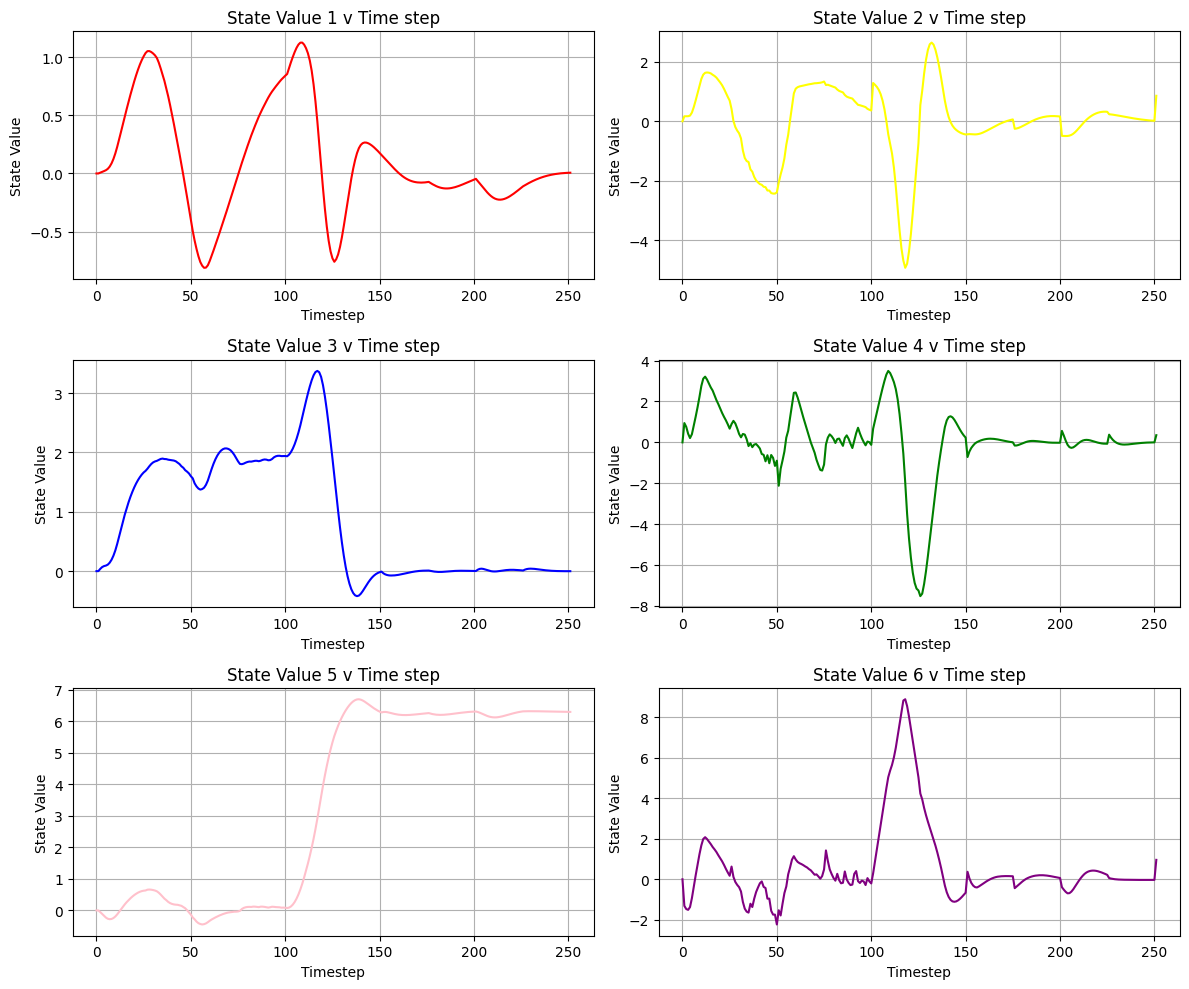

In [14]:
#To plot the graph of state x with each timestep
timesteps = list(range(252))
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
colors = ["red", "yellow", "blue", "green", "pink", "purple"]
axs = axs.flatten()

# Plot each state value in a separate subplot
for i in range(6):
    axs[i].plot(timesteps, states[i], color = colors[i])
    axs[i].set_title(f'State Value {i+1} v Time step')
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel('State Value')
    axs[i].grid()

plt.tight_layout()
plt.show()

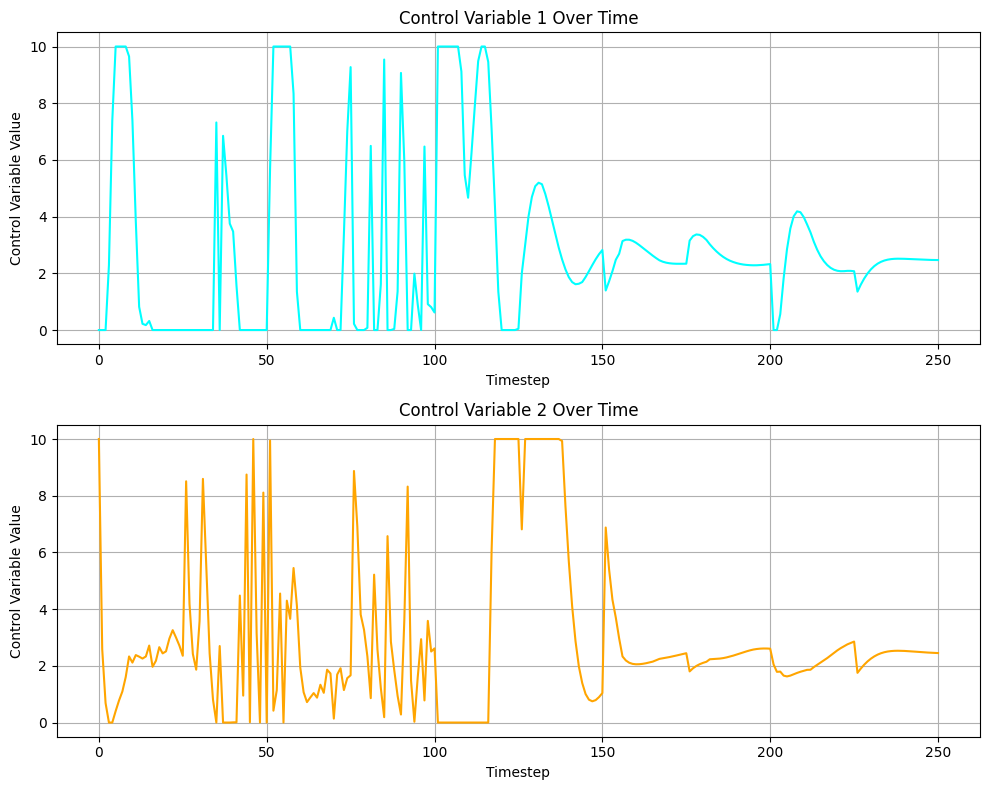

In [15]:
#To plot the graph of control u with each timestep
timesteps = list(range(251))
control1, control2 = controls

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot the first control variable
axs[0].plot(timesteps, control1, linestyle='-', color='cyan')
axs[0].set_title('Control Variable 1 Over Time')
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Control Variable Value')
axs[0].grid()

# Plot the second control variable
axs[1].plot(timesteps, control2, linestyle='-', color='orange')
axs[1].set_title('Control Variable 2 Over Time')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Control Variable Value')
axs[1].grid()


plt.tight_layout()
plt.show()

## BONUS

In [16]:
#Change inequality constraints to keep -py <= 0

#Since we need altitude to stay positive we must change cost function (path 3) so that drone is not pushed to y = 0
def f_n2(x, path):
    n = x.shape[0]//8
    cost = 0
    if path == 0:
        for i in range(n):
            cost += 15*((x[8*i] - 1)**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2] - 1)**2)
            + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - (math.pi/2))**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2)  
    elif path == 1:
        for i in range(n):
            cost += 15*((x[8*i])**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2] - 2)**2)
            + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - math.pi)**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2) 
    elif path == 3:
        for i in range(n):
            cost += 15*((x[8*i])**2) + 0.1*(x[8*i+1]**2) + 15*((x[8*i+2] - 0.5)**2)
            + 0.1*(x[8*i+3]**2) + 15*((x[8*i+4] - (2*math.pi))**2) + 0.1*(x[8*i+5]**2) + 0.1*(x[8*i+6]**2) + 0.1*(x[8*i+7]**2) 

    return cost
        
def grad_f_n2(x, path):
    df = np.zeros(x.shape[0])
    n = x.shape[0]//8

    if path == 0:
        for i in range(n):
            df[8*i] = 30*(x[8*i] - 1)
            df[8*i + 1] = 0.2*(x[8*i + 1])
            df[8*i + 2] = 30*(x[8*i + 2]  - 1)
            df[8*i + 3] = 0.2*(x[8*i + 3])
            df[8*i + 4] = 30*(x[8*i + 4]  - (math.pi/2))
            df[8*i + 5] = 0.2*(x[8*i + 5])
            df[8*i + 6] = 0.2*(x[8*i + 6])
            df[8*i + 7] = 0.2*(x[8*i + 7])      

    if path == 1:
        for i in range(n):
            df[8*i] = 30*(x[8*i])
            df[8*i + 1] = 0.2*(x[8*i + 1])
            df[8*i + 2] = 30*(x[8*i + 2]  - 2)
            df[8*i + 3] = 0.2*(x[8*i + 3])
            df[8*i + 4] = 30*(x[8*i + 4]  - (math.pi))
            df[8*i + 5] = 0.2*(x[8*i + 5])
            df[8*i + 6] = 0.2*(x[8*i + 6])
            df[8*i + 7] = 0.2*(x[8*i + 7])       

    if path == 3:
        for i in range(n):
            df[8*i] = 30*(x[8*i])
            df[8*i + 1] = 0.2*(x[8*i + 1])
            df[8*i + 2] = 30*(x[8*i + 2] - 0.5)
            df[8*i + 3] = 0.2*(x[8*i + 3])
            df[8*i + 4] = 30*(x[8*i + 4]  - (2*math.pi))
            df[8*i + 5] = 0.2*(x[8*i + 5])
            df[8*i + 6] = 0.2*(x[8*i + 6])
            df[8*i + 7] = 0.2*(x[8*i + 7])       

    return df    

#h(x) and grad h
def get_u_n(x):
    n = x.shape[0]//8
    u_1 = np.zeros((5*n))
    for i in range(n):
        u_1[5*i] = -x[8*i + 6]
        u_1[5*i + 1] = x[8*i + 6] - 10
        u_1[5*i + 2] = -x[8*i + 7]
        u_1[5*i + 3] = x[8*i + 7] - 10
        u_1[5*i + 4] = -x[8*i + 2]

    return u_1

def grad_u_n(x):

    n = x.shape[0]//8
    b = np.zeros((5*n, 8*n))
    for i in range(n):
        b[5*i: 5*i + 5, 8*(i): 8*(i) + 8] = [
            [0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, -1],
            [0, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, -1, 0, 0, 0, 0, 0],
        ]

    return b

def c_n2(x, x_start):
    g_x = g_n(x, x_start)
    constraint_violation = 0
    for i in range(g_x.shape[0]):
        constraint_violation += abs(g_x[i])

    u_x = get_u_n(x)
    ineq_violation = 0
    for i in range(u_x.shape[0]):
        if u_x[i] > 0:
            ineq_violation+= u_x[i]

    return constraint_violation + ineq_violation

def line_search_n2(x, px , f_best, c_best, path, x_start):
    t = 0.5
    a = 1

    while True:
        if a < 10e-5:
            return a, f_best, c_best
        
        #Calculate running cost with x = x_old + a*px and seeing if it is better than before
        f_t = np.linalg.norm(f_n2(x + a*px, path))
        if f_t < f_best:
            f_best = f_t
            return a, f_best, c_best
        
        #Calculate total constraint violation with x = x_old + a*px and seeing if it is better than before
        c_t = c_n2(x + a*px, x_start)
        if c_t < c_best:
            c_best = c_t
            return a, f_best, c_best
    
        #Updating alpha to t*alpha and repeating till condition is met (0 < t < 1)
        a = t*a

In [17]:
def do_SQP2(x_start, path):
    timesteps = 75
    n_vars = 8
    n_total = n_vars*timesteps
    n_constraints = timesteps*6
    n_ineq = timesteps*5

    #initialise best running cost and conostraint violation to infiinity just for first iteration in filter line search
    f_best = np.inf
    c_best = np.inf

    alphas = []
    costs = []
    constr_vio = []
    iters = 0

    #Start with starting values of x0 and arbitrary lambda

    x = np.zeros((n_total, 1))
    x[:6] = x_start.reshape((6,1))
    lmbda = np.zeros((n_constraints, 1))
    mu = np.zeros((n_ineq, 1))
    # print(f"Num of timesteps: {timesteps}")

    for i in range(50):
        iters += 1
        #Getting all the elements for KKT matrix
        hess = hessian(x)
        gradient_f = grad_f_n2(x, path)
        g_x = g_n(x, x_start)
        gradient_g = grad_g(x)
        u_x = get_u_n(x)
        gradient_u = grad_u_n(x)

        problem = Problem(hess, gradient_f, gradient_u, -u_x, gradient_g, -g_x, None, None)

        p = solve_problem(problem, solver="cvxopt")

        px = p.x.reshape((p.x.shape[0], 1))
        plambda = p.y.reshape((p.y.shape[0], 1))
        pmu = p.z.reshape((p.z.shape[0], 1))

        a, f_best, c_best = line_search_n2(x, px, f_best, c_best, path, x_start)
        # print(f"best alpha is {a}\n")

        #Update x values and Lambda values
        x = x + a*px
        lmbda = (1-a)*lmbda + a*plambda
        mu = (1-a)*mu + a*pmu

        #Threshold for when to stop optimizing is when lagrangian is minimized and constraints are minimized or when maximum iterations are reached
        lagrangian_x = grad_f_n2(x, path) + grad_g(x).transpose()@lmbda + grad_u_n(x).transpose()@mu
        lagrangian_lmbda = g_n(x, x_start)
        lagrangian_mu = get_u_n(x)

        # print(f"Iteration number{i}")

        lag_x_sum = np.abs(np.sum(lagrangian_x))
        lag_lmbda_sum = np.sum(np.abs(lagrangian_lmbda))
        lag_mu_sum = get_ineq_sum(lagrangian_mu)


        constr_vio.append(lag_lmbda_sum)
        alphas.append(a)
        costs.append(np.sum(f_n2(x, path)))

        if lag_x_sum < 0.01 or lag_lmbda_sum < 0.01:
            break    

    x_guess = x[8:16]
    ua, ub = x[6], x[7]

    return ua, ub

In [18]:
from qpsolvers import Problem, solve_problem

In [19]:
x_init = np.array([0, 0, 0, 0, 0, 0])
a=6
b=2

def controller(x1, t):
  if t <= 30:
    path = 0
  elif t <= 100:
    path = 1
  else:
    path = 3

  ua, ub = do_SQP2(x1, path)
  return np.array([ua.item(), ub.item()])

t, state, u = quadrotor.simulate(x_init, controller, 251, disturbance=True)
quadrotor.animate_robot(state, u)

C:\Users\megh2\AppData\Local\Temp\ipykernel_30076\3756900265.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i] = 30*(x[8*i] - 1)
C:\Users\megh2\AppData\Local\Temp\ipykernel_30076\3756900265.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i + 1] = 0.2*(x[8*i + 1])
C:\Users\megh2\AppData\Local\Temp\ipykernel_30076\3756900265.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[8*i + 2] = 30*(x[8*i + 2]  - 1)
C:\Users\megh2\AppData\Local\Temp\i

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA1I9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EV1liIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eKwmYcBqJCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBk/h85TXs1E4/wzb/2kGNoKOUz+RzSfXk3eeTMCjNgTJ5NKBn4bYY/l8VWN5leDx1ux0u0fvaZ
OYTt7nHytnMp39ZMLuXxtXaR7rleXMVFfF/NxUbeBQmwOC7Lx/opNBqhx/5cueJjt7O55GH/QhWB
f591+qoBKpqvyFJzOTzqReBYx8P79mJdx0Mv+HL4+yScuS/TXcCVmU4JjCoFYoGBPXCZbXDvgpiV
gQsntI/1j0mCl/HlqRi8vRBi5IUQB9YfGmLsm+5OTwAAjzSzqVFYAVBYGES885zm3UxefD6TMch9
4nx23yUWpVXA9gAJnBtxn1KttjqMuv0hoHA+QkSqlStgWDhxMcJPIEYzv/fNzixDkAa1u990tnQU
Ye32TpiQnSYyvrSXxwp4iqzoeAzQkbU6NjjfiwGYLFiLvtclki63gqE2E5xzLRlK3LahaRXdHrWo
97lgG7U9uzEXN0WJ9XvlSxKPIPEDWE5HRGz7F/FZMQTdF7QvYqXPK8BvIcdsw2AAmCyJIYIb9IQ7
cM43Q8IrQSy1+OZ0MEJlXC+wzVGdriG9KlVyjQhuSJATgWbr8skkZHztYz1X2vMZlAAZuMWSWmMD
xUrcmG8hcu7bo7/hwVwWvWDgKwmeYifc/v0yh00I9s6K3pQ7C5I7g/T2eH89ugZo1dxoumNPog/g
RqIqmGjzYJQEFolHG/GPNu9/7L3ir5BRDT21SxQB041PHWpO47XnFIkDZ3B04J/IwLiznsxH93zL
8gkcSCASrlak2y7i+ShgFS7FkiB+hk63FDornRLFfpC8yBOXKuPDEo4TEZyNSmVKVa/Vpq3T4m0X
hdycZn1SOCMDs/1q8v9IRGzl2hmavJpYY+J6O22B7kMNA5/+22FxE+FDE68lTa8n2SKFRQ336KLm
Kzf7NPAzUYc4W1o/PrQQJINVe2sc+LWvKzKxd8XgM0/H/3iraIGQu32gtR3T8siAAAADAE2krzMm
mPW21ZXjpWocJK5H1hmAAHbMW3RbWrEges2pUXxsNwvpvwIhMPnw9jV16uAYHFQazjj2lfvAMR0T
d14IXldWfHLv89W5NoRid2HPabwU56fxwFIxiEj+ITKcQNNihK3aBYCbRfNBoZvaZv8TDeIJWWgl
cz8RvgvYmnAlpQLj7xnBbKxkm/b+QPKC9/OhHQXZKeFPYvWo8IT+7PoNu4eWiLOzKn9ReDNo+Ff1
A7+VtpDgOHz692WEo/C73

In [20]:
states = [state[0], state[1], state[2], state[3], state[4], state[5]]
controls = [np.array(u[0]), np.array(u[1])]

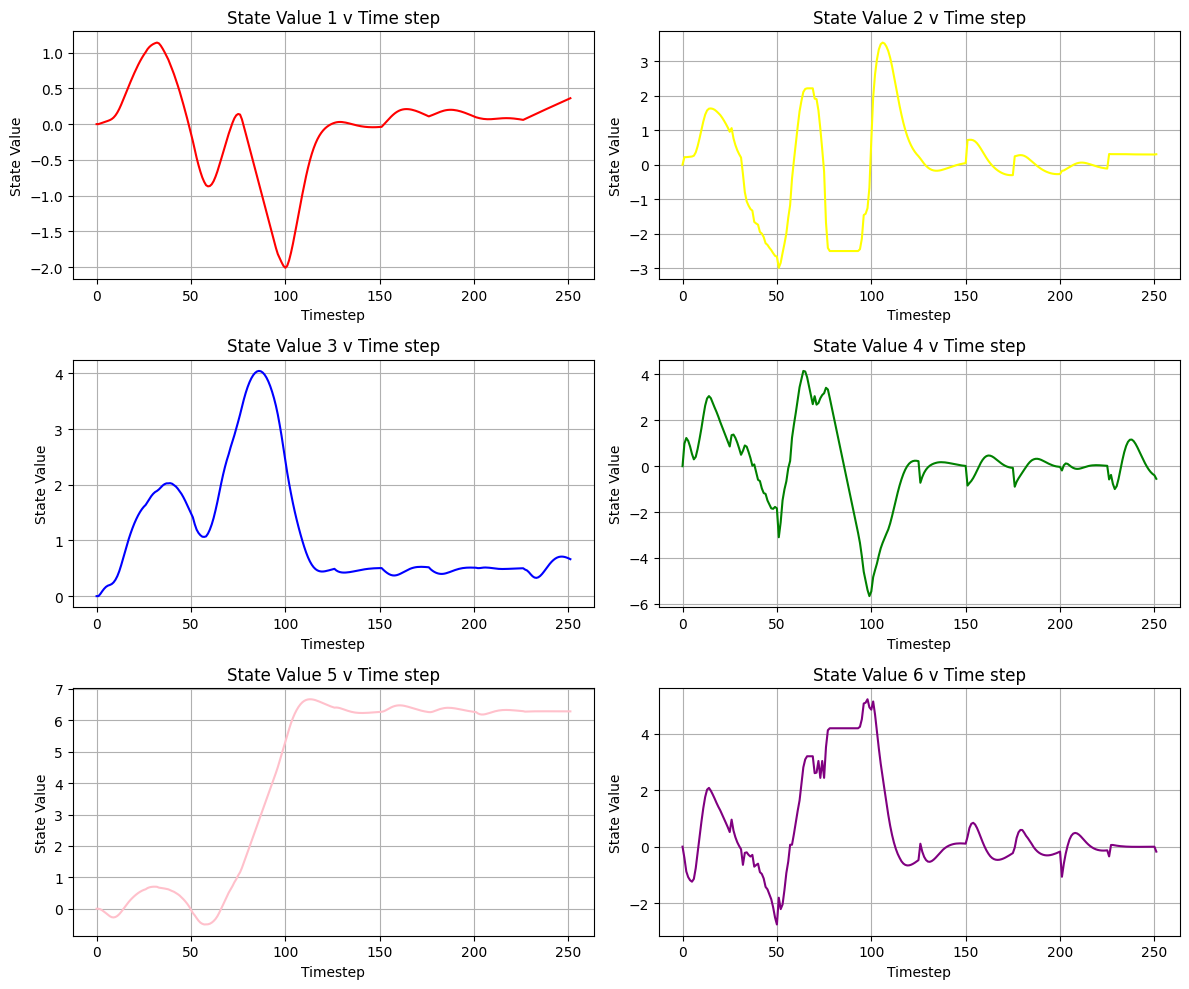

In [21]:
#To plot the graph of state x with each timestep
timesteps = list(range(252))
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
colors = ["red", "yellow", "blue", "green", "pink", "purple"]
axs = axs.flatten()

# Plot each state value in a separate subplot
for i in range(6):
    axs[i].plot(timesteps, states[i], color = colors[i])
    axs[i].set_title(f'State Value {i+1} v Time step')
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel('State Value')
    axs[i].grid()

plt.tight_layout()
plt.show()

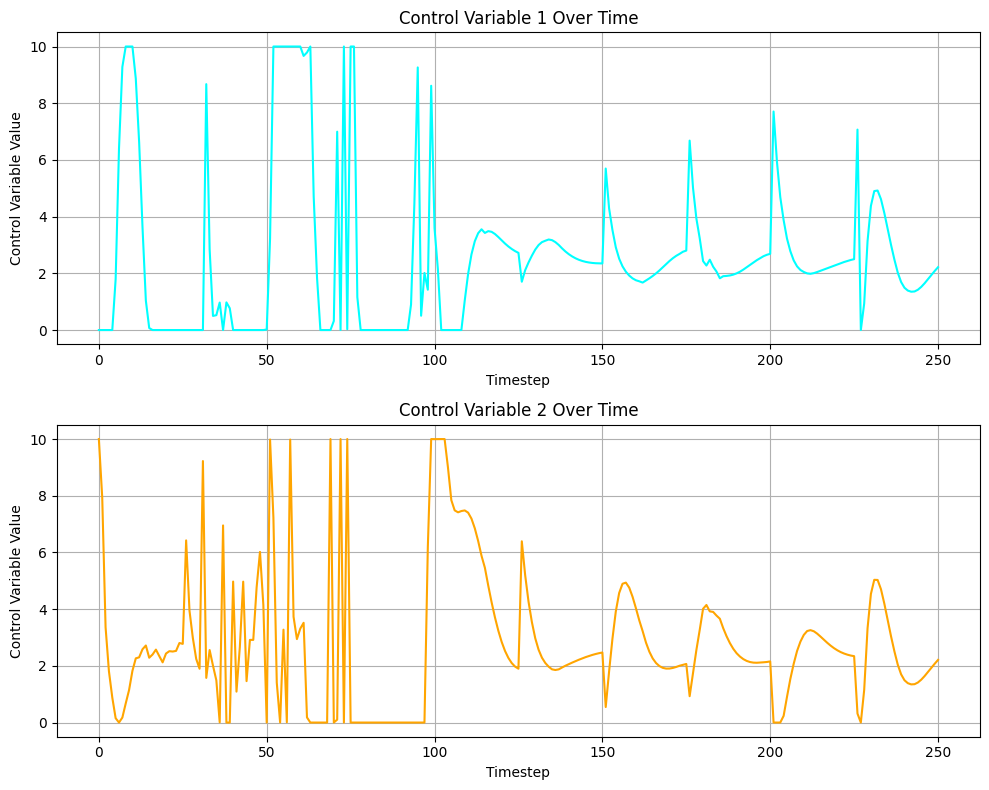

In [22]:
#To plot the graph of control u with each timestep
timesteps = list(range(251))
control1, control2 = controls

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot the first control variable
axs[0].plot(timesteps, control1, linestyle='-', color='cyan')
axs[0].set_title('Control Variable 1 Over Time')
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Control Variable Value')
axs[0].grid()

# Plot the second control variable
axs[1].plot(timesteps, control2, linestyle='-', color='orange')
axs[1].set_title('Control Variable 2 Over Time')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Control Variable Value')
axs[1].grid()


plt.tight_layout()
plt.show()